Imports and Data Download

In [ ]:
import kagglehub
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from google.colab import files

print("Downloading dataset...")
DATA_DIR = kagglehub.dataset_download('imranliaqat32/autism-spectrum-disorder-in-childrenhandgestures')
ACTUAL_DATA_DIR = os.path.join(DATA_DIR, 'Thesis Dataset')
print("Download complete.")

Using Colab cache for faster access to the 'autism-spectrum-disorder-in-childrenhandgestures' dataset.
Download complete.


Data Structuring (Binary Mapping) & Preprocessing

In [ ]:
data = []
for condition in os.listdir(ACTUAL_DATA_DIR):
    condition_path = os.path.join(ACTUAL_DATA_DIR, condition)
    if os.path.isdir(condition_path):
        # Mapping: ASD and ASD with CD -> 'yes' | Non-ASD -> 'no'
        label = 'no' if condition == 'Non-ASD' else 'yes'
        for root, dirs, files_list in os.walk(condition_path):
            for file in files_list:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    data.append({'filepath': os.path.join(root, file), 'label': label})

df = pd.DataFrame(data)
print(f"Total images found: {len(df)}")
print(f"Class Distribution:\n{df['label'].value_counts()}")

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

train_gen = datagen.flow_from_dataframe(
    df, x_col='filepath', y_col='label',
    target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='binary', subset='training', shuffle=True
)

val_gen = datagen.flow_from_dataframe(
    df, x_col='filepath', y_col='label',
    target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='binary', subset='validation', shuffle=False
)

Total images found: 1739
Class Distribution:
label
yes    1174
no      565
Name: count, dtype: int64
Found 1392 validated image filenames belonging to 2 classes.
Found 347 validated image filenames belonging to 2 classes.


Initial Training (Frozen Backbone)

In [ ]:
print("Building Model with Frozen ResNet50 Backbone...")
base_model = tf.keras.applications.ResNet50(
    weights='imagenet', include_top=False, input_shape=(224, 224, 3)
)
base_model.trainable = False  # Freeze pre-trained weights

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid') # Binary output
])

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("Starting Initial Training (5 Epochs)...")
history = model.fit(train_gen, validation_data=val_gen, epochs=5)

Building Model with Frozen ResNet50 Backbone...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Starting Initial Training (5 Epochs)...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 269s 6s/step - accuracy: 0.7578 - loss: 0.5219 - val_accuracy: 0.0000e+00 - val_loss: 1.1865
Epoch 2/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 256s 6s/step - accuracy: 0.8274 - loss: 0.4231 - val_accuracy: 0.0000e+00 - val_loss: 1.9175
Epoch 3/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 253s 6s/step - accuracy: 0.8431 - loss: 0.3582 - val_accuracy: 0.0000e+00 - val_loss: 1.4593
Epoch 4/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 258s 6s/step - accuracy: 0.8432 - loss: 0.3711 - val_accuracy: 0.0000e+00 - val_loss: 1.6516
Epoch 5/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 253s 6s/step - accuracy: 0.8464 - loss: 0.3661 - val_accuracy: 0.0173 - val_loss: 1.1700


Fine-Tuning (Unfreezing Top Layers)

In [ ]:
print("\nUnfreezing Top Layers for Fine-Tuning...")
base_model.trainable = True

# Freeze all layers except the last 30
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Re-compile with a much lower learning rate
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.00001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("Starting Fine-Tuning (10 Epochs)...")
fine_tune_history = model.fit(train_gen, validation_data=val_gen, epochs=10)


Unfreezing Top Layers for Fine-Tuning...
Starting Fine-Tuning (10 Epochs)...
Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 356s 8s/step - accuracy: 0.7441 - loss: 0.6395 - val_accuracy: 0.0000e+00 - val_loss: 2.8272
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 335s 8s/step - accuracy: 0.8154 - loss: 0.4556 - val_accuracy: 0.0000e+00 - val_loss: 7.1251
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 368s 8s/step - accuracy: 0.8415 - loss: 0.3613 - val_accuracy: 0.0000e+00 - val_loss: 9.1286
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 334s 8s/step - accuracy: 0.8592 - loss: 0.3470 - val_accuracy: 0.0029 - val_loss: 4.6572
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 340s 8s/step - accuracy: 0.8666 - loss: 0.3262 - val_accuracy: 0.5331 - val_loss: 0.6891
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 333s 8s/step - accuracy: 0.8374 - loss: 0.3916 - val_accuracy: 1.0000 - val_loss: 0.0053
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 343s 8s/step - accuracy: 0.8691 - loss: 0.3330 - val_accuracy: 1.0000 - val_loss: 0.0061
Epoch 8/10
44/44 ━━━━

Plotting and Auto-Download

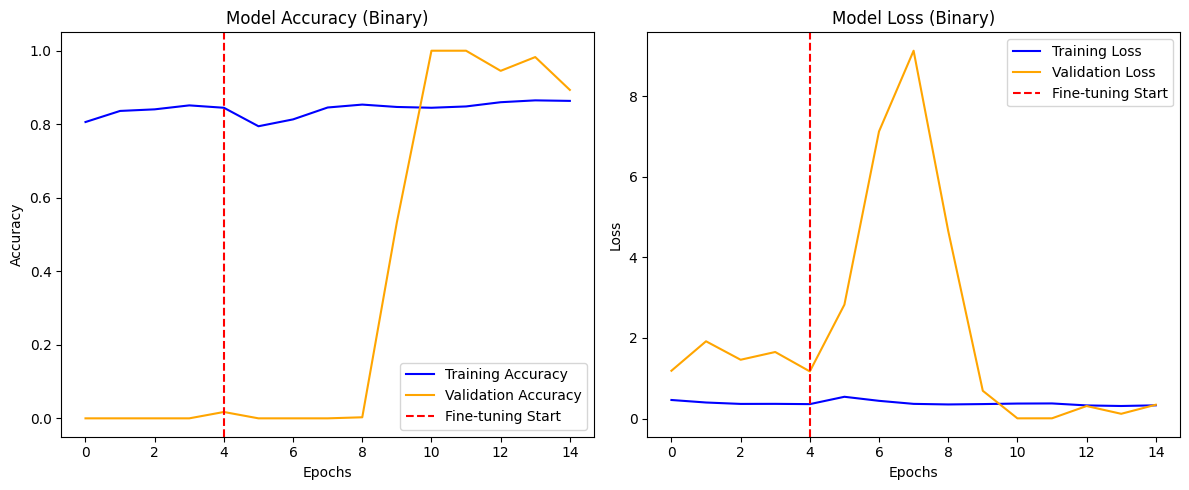

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def plot_results(hist1, hist2):
    acc = hist1.history['accuracy'] + hist2.history['accuracy']
    val_acc = hist1.history['val_accuracy'] + hist2.history['val_accuracy']
    loss = hist1.history['loss'] + hist2.history['loss']
    val_loss = hist1.history['val_loss'] + hist2.history['val_loss']

    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy', color='blue')
    plt.plot(val_acc, label='Validation Accuracy', color='orange')
    plt.axvline(x=4, color='r', linestyle='--', label='Fine-tuning Start')
    plt.title('Model Accuracy (Binary)')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss', color='blue')
    plt.plot(val_loss, label='Validation Loss', color='orange')
    plt.axvline(x=4, color='r', linestyle='--', label='Fine-tuning Start')
    plt.title('Model Loss (Binary)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()

    # Save the figure in high resolution
    filename = 'binary_training_results.png'
    plt.savefig(filename, dpi=300)
    plt.show()

    # Automatically download the file to your computer
    print(f"Downloading {filename}...")
    files.download(filename)

plot_results(history, fine_tune_history)